# An analysis of video memorability using Caption features
Yong Shoun_PHO_19211938

## I. Setting up

Mouting Gdrive and setting up the default directory

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/Study/DCU Semester 2/Machine Learning/CA684_Assignment/')

Installing extra libraries

In [ ]:
!pip install pyprind
!pip install textblob
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
import pandas as pd
import numpy as np

from keras import Sequential
from keras import layers
from keras import regularizers
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
import nltk

from textblob import Word

import pickle

from string import punctuation
import pyprind
from collections import Counter
import matplotlib.pyplot as plt

Using TensorFlow backend.


## II. Basic functions

Calculate Spearman Score

In [ ]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

## III. Loading the data

In [ ]:
# load labels and captions
def read_caps(filename):
    """Load the captions into a dataframe"""
    thevideos = []
    thecaptions = []
    temp_df = pd.DataFrame();
    with open(filename) as f:
        for line in f:
            pairs = line.split()
            thevideos.append(pairs[0])
            thecaptions.append(pairs[1])
        temp_df['video']=thevideos
        temp_df['caption']=thecaptions
    return temp_df


# load the captions
cap_path = './Dev-set/Captions/dev-set_video-captions.txt'
df_caption = read_caps(cap_path)

# load the ground truth values
label_path = './Dev-set/Ground-truth/'
df_labels = pd.read_csv(label_path+'ground-truth.csv')

In [ ]:
df_caption.head(3)

,video,caption
0,video3.webm,blonde-woman-is-massaged-tilt-down
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot
2,video6.webm,khr-gangsters


In [ ]:
df_labels.head(3)

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10


## IV. Preprocessing the data

### 1.   Remove punctuation and lowercase captions





In [ ]:
# replace punctuations with space
# convert words to lower case

for i, cap in enumerate(df_caption['caption']):
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    df_caption.loc[i,'caption'] = text

df_caption.head(3)

,video,caption
0,video3.webm,blonde woman is massaged tilt down
1,video4.webm,roulette table spinning with ball in closeup shot
2,video6.webm,khr gangsters


### 2.   Remove numbers in caption


In [ ]:
# remove numbers in captions

df_caption.caption.replace({r"[^a-z ]" : ''}, inplace= True, regex = True)

df_caption.head(3)

,video,caption
0,video3.webm,blonde woman is massaged tilt down
1,video4.webm,roulette table spinning with ball in closeup shot
2,video6.webm,khr gangsters


### 3.   Remove stop words

In [ ]:
# setting stopwords

nltk.download('stopwords')
stopwords.words("english") # get english stopwords
stopwordsList = stopwords.words('english')

# remove stopwords
df_caption.caption = df_caption.caption.apply(lambda a_word: " ".join(i for i in a_word.split() if i not in stopwordsList)) 

df_caption.head(3)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,video,caption
0,video3.webm,blonde woman massaged tilt
1,video4.webm,roulette table spinning ball closeup shot
2,video6.webm,khr gangsters


### 4.   Lemmatization


In [ ]:
# Captions Lemmatization

df_caption.caption = df_caption.caption.apply(lambda x: " ".join([Word(i).lemmatize() for i in x.split()]))

df_caption.head(3)

,video,caption
0,video3.webm,blonde woman massaged tilt
1,video4.webm,roulette table spinning ball closeup shot
2,video6.webm,khr gangster


### 5.   Join df_caption and df_label

In [ ]:
# Join datasets
data = df_caption.merge(df_labels,on=["video"],how="inner")

data.head(3)

,video,caption,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,blonde woman massaged tilt,0.924,34,0.846,13
1,video4.webm,roulette table spinning ball closeup shot,0.923,33,0.667,12
2,video6.webm,khr gangster,0.863,33,0.700,10


## V. Featurization

Upon building a data model, featurization of the data is an important step that are mostly forgotten as we use in most case TF-IDF with n-gram. But is it the best way to weight words

In [ ]:
# Bag of Words

from sklearn.feature_extraction.text import CountVectorizer

bagOfWords = CountVectorizer(min_df=1)
X_bagOfWords = bagOfWords.fit_transform(data.caption)
X_bagOfWords =X_bagOfWords.toarray()

print(X_bagOfWords.shape)
X_bagOfWords

(6000, 4542)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# TF - IDF

from sklearn.feature_extraction.text import TfidfVectorizer

tf_Idf = TfidfVectorizer()
X_tf_Idf = tf_Idf.fit_transform(data.caption)
X_tf_Idf =X_tf_Idf.toarray()

print(X_tf_Idf.shape)
X_tf_Idf

(6000, 4542)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# TF - IDF with n-gram

from sklearn.feature_extraction.text import TfidfVectorizer

ngram = TfidfVectorizer(ngram_range = (1,4))
X_ngram = ngram.fit_transform(data.caption)
X_ngram =X_ngram.toarray()

print(X_ngram.shape)
X_ngram

(6000, 58534)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## VI. Building NN models

Because we test multiple featurization, we create a function to split data according to the featurization used

In [ ]:
def splitData(X_ttrain):
  Y = data[['short-term_memorability','long-term_memorability']].values
  X = X_ttrain
  X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=88)

  print(X_train.shape)
  print(X_test.shape)
  print(Y_train.shape)
  print(Y_test.shape)
  return;

Because we test multiple featurization, we create a function that create the NN according to the featurization used

In [ ]:
def NN(X_ttrain):
  from keras import layers
  from keras.layers import Dropout # layer to avoid overfitting

  model = Sequential()
  model.add(layers.Dense(100,activation='relu',kernel_regularizer=regularizers.l2(0.0005),input_shape=(X_ttrain.shape[1],))) # layer 1
  model.add(layers.Dropout(0.5)) # layer 2
  model.add(layers.Dense(100,activation='relu',kernel_regularizer=regularizers.l2(0.0005))) # layer 3
  model.add(layers.Dropout(0.5)) # layer 4
  model.add(layers.Dense(2,activation='sigmoid')) # layer 5
  
  return model;

## VII. Train NN models

### Bag of Words

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 2s 499us/step - loss: 0.0514 - accuracy: 0.6942 - val_loss: 0.0192 - val_accuracy: 0.7083
Epoch 2/20
4800/4800 [==============================] - 1s 270us/step - loss: 0.0171 - accuracy: 0.7038 - val_loss: 0.0151 - val_accuracy: 0.7083
Epoch 3/20
4800/4800 [==============================] - 1s 255us/step - loss: 0.0151 - accuracy: 0.7040 - val_loss: 0.0143 - val_accuracy: 0.7083
Epoch 4/20
4800/4800 [==============================] - 1s 262us/step - loss: 0.0147 - accuracy: 0.7042 - val_loss: 0.0141 - val_accuracy: 0.7083
Epoch 5/20
4800/4800 [==============================] - 1s 258us/step - loss: 0.0144 - accuracy: 0.7040 - val_loss: 0.0140 - val_accuracy: 0.7083
Epoch 6/20
4800/4800 [==============================] - 1s 259us/step - loss: 0.0145 - accuracy: 0.7040 - val_loss: 0.0141 - val_accuracy: 0.7083
Epoch 7/20
4800/4800 [==============================] - 1s 263us/step - loss

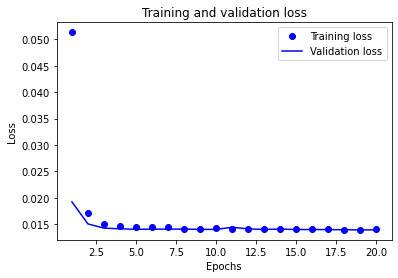

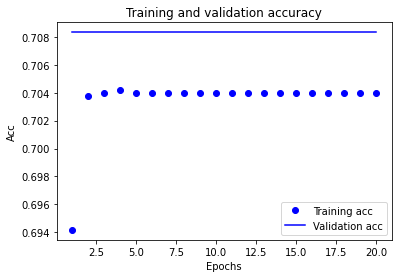

In [ ]:
# For Bag of word

Y = data[['short-term_memorability','long-term_memorability']].values
X = X_bagOfWords
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=88)

model1 = NN(X_bagOfWords)


# training starts here

model1.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])
model_fit = model1.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

# visualizing the model
loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

We can see an overfitting from the first to the 8th epoch on training/validation loss graph. The issue is resolved as we go through the 8th epoch.

On the validation/training accuracy graph, we can see training accuracy is always under validation accuracy and might be underfitting. Howerver the difference between these two parameters from epoch 10 is about 0.004. 

Validation accuracy is at about 0.708.

### TF-IDF

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 1s 297us/step - loss: 0.0520 - accuracy: 0.6540 - val_loss: 0.0185 - val_accuracy: 0.7083
Epoch 2/20
4800/4800 [==============================] - 1s 247us/step - loss: 0.0172 - accuracy: 0.7029 - val_loss: 0.0149 - val_accuracy: 0.7083
Epoch 3/20
4800/4800 [==============================] - 1s 250us/step - loss: 0.0152 - accuracy: 0.7040 - val_loss: 0.0145 - val_accuracy: 0.7083
Epoch 4/20
4800/4800 [==============================] - 1s 248us/step - loss: 0.0149 - accuracy: 0.7040 - val_loss: 0.0144 - val_accuracy: 0.7083
Epoch 5/20
4800/4800 [==============================] - 1s 242us/step - loss: 0.0147 - accuracy: 0.7040 - val_loss: 0.0143 - val_accuracy: 0.7083
Epoch 6/20
4800/4800 [==============================] - 1s 245us/step - loss: 0.0145 - accuracy: 0.7040 - val_loss: 0.0143 - val_accuracy: 0.7083
Epoch 7/20
4800/4800 [==============================] - 1s 248us/step - loss

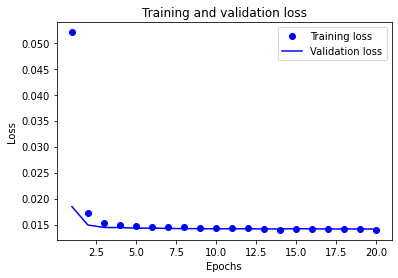

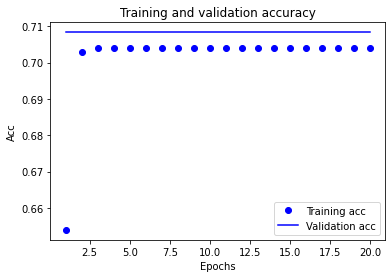

In [ ]:
# For TF-IDF

Y = data[['short-term_memorability','long-term_memorability']].values
X = X_tf_Idf
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=88)

model2 = NN(X_tf_Idf)

# training starts here

model2.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])
model_fit = model2.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

# visualizing the model
loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

We can see an overfitting from the first to the 8th epoch on training/validation loss graph. The issue is resolved as we go through the 8th epoch.

On the validation/training accuracy graph, we can see training accuracy is always under validation accuracy and might be underfitting. The difference between these two parameters from epoch 10 is about 0.04. 

Validation accuracy is at about 0.708.

### TF-IDF + ngram

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 13s 3ms/step - loss: 0.0463 - accuracy: 0.6631 - val_loss: 0.0186 - val_accuracy: 0.7083
Epoch 2/20
4800/4800 [==============================] - 13s 3ms/step - loss: 0.0173 - accuracy: 0.7035 - val_loss: 0.0156 - val_accuracy: 0.7083
Epoch 3/20
4800/4800 [==============================] - 13s 3ms/step - loss: 0.0156 - accuracy: 0.7040 - val_loss: 0.0149 - val_accuracy: 0.7083
Epoch 4/20
4800/4800 [==============================] - 13s 3ms/step - loss: 0.0152 - accuracy: 0.7040 - val_loss: 0.0148 - val_accuracy: 0.7083
Epoch 5/20
4800/4800 [==============================] - 13s 3ms/step - loss: 0.0151 - accuracy: 0.7040 - val_loss: 0.0147 - val_accuracy: 0.7083
Epoch 6/20
4800/4800 [==============================] - 13s 3ms/step - loss: 0.0149 - accuracy: 0.7040 - val_loss: 0.0147 - val_accuracy: 0.7083
Epoch 7/20
4800/4800 [==============================] - 13s 3ms/step - loss: 0.014

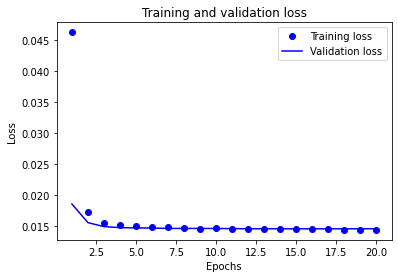

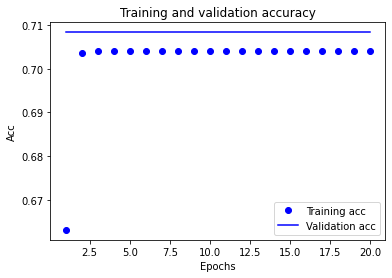

In [ ]:
# For TF-IDF + ngram

Y = data[['short-term_memorability','long-term_memorability']].values
X = X_ngram
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=88)

model3 = NN(X_ngram)


# training starts here

model3.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])
model_fit = model3.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

# visualizing the model
loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

We can see an overfitting from the first to the 8th epoch on training/validation loss graph. The issue is resolved as we go through the 8th epoch.

On the validation/training accuracy graph, we can see training accuracy is always under validation accuracy and might be underfitting. The difference between these two parameters from epoch 10 is about 0.04. 

Validation accuracy is at about 0.708.

In conclusion, it seems that while training the model on BoW, TF-IDF and TF-IDF 4-gram, they both have about the same curve on training/validation loss graph. However, it can be clearly seen that on training/validation accuracy graph, BoW while underfitting is clearly doing better as the difference after more than 10 epoch is of about 0.004 compared to 0.04 on TF-IDF and TF-IDF 4-gram.
Moreover we can say that TF-IDF and n-gram are very similar.

## VIII. NN Predictions

Bag of Words

In [ ]:
# get the right weighting vector for the model
X = X_bagOfWords
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=88)

#predict and Pearson coeff
predictions1 = model1.predict(X_test)
Get_score(predictions1, Y_test)

The Spearman's correlation coefficient is: 0.354
The Spearman's correlation coefficient is: 0.170


TF-IDF

In [ ]:
# get the right weighting vector for the model again
X = X_tf_Idf
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=88)

#predict and Pearson coeff
predictions2 = model2.predict(X_test)
Get_score(predictions2, Y_test)

The Spearman's correlation coefficient is: 0.304
The Spearman's correlation coefficient is: 0.165


TF-IDF + ngram

In [ ]:
# get the right weighting vector for the model again
X = X_ngram
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=88)

#predict and Pearson coeff
predictions3 = model3.predict(X_test)
Get_score(predictions3, Y_test)

The Spearman's correlation coefficient is: 0.075
The Spearman's correlation coefficient is: 0.061


It is with no surprise that Spearman's correlation coefficient is more efficient on BoW as we have previously seen that using BoW is clearly better than TF-IDF and TF-IDF n-gram do to a better management of underfitting the validation/training accuracy.
In another hand, it is surprising to see thaTF-IDF + 4gram is behaving this bad as the we initially thought that it was quite similar to TF-IDF in term of loss and accuracy.

## IX. Save NN results

In [ ]:
path = "/content/drive/My Drive/Study/DCU Semester 2/Machine Learning/"

prediction1 = pd.DataFrame(predictions1, columns=['Short_term_score','Long_term_score']).to_csv(path+'/NN_model1_predictions.csv')
prediction2 = pd.DataFrame(predictions2, columns=['Short_term_score','Long_term_score']).to_csv(path+'./NN_model2_predictions.csv')
prediction3 = pd.DataFrame(predictions3, columns=['Short_term_score','Long_term_score']).to_csv(path+'./NN_model3_predictions.csv')

model1.save(path+'NN_model1_on_caption.h5') # BoW
model2.save(path+'NN_model2_on_caption.h5') # TF-IDF
model3.save(path+'NN_model3_on_caption.h5') # TF-IDF + ngram

## X. Building SVR model

SVR model is the SVM for continious variables and is a fit in our case.

In [ ]:
from sklearn.svm import SVR
path = "/content/drive/My Drive/Study/DCU Semester 2/Machine Learning/"

## XI. Linear kernel

### Bag of word

In [ ]:
# Get the ground truth and split the data into train and test set
Y_short = df_labels[['short-term_memorability']].values # take short term memorability as label
X = X_bagOfWords;
X_train, X_test, Y_train_short, Y_test_short = train_test_split(X,Y_short, test_size=0.2, random_state=42)

# fit the model
modelSVR_short = SVR(C=100, kernel='linear').fit(X_train,Y_train_short)

# prediction and getting Pearson coefficient
predictionsSVR_short = modelSVR_short.predict(X_test)
Get_score(predictionsSVR_short,Y_test_short)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.238


In [ ]:
# Get the ground truth and split the data into train and test set
Y_long = df_labels[['long-term_memorability']].values # take long term memorability as label
X_train, X_test,Y_train_long, Y_test_long = train_test_split(X,Y_long, test_size=0.2, random_state=42)

# fit the model
modelSVR_long = SVR(C=100, kernel='linear').fit(X_train,Y_train_long)

# prediction and getting Pearson coefficient
predictionsSVR_long = modelSVR_long.predict(X_test)
Get_score(predictionsSVR_long,Y_test_long)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.064


In [ ]:
# Save the results

# merge the short term and long term score into a dataset
data_frame = pd.DataFrame(predictionsSVR_short) 
data_frame['Long_term_score'] = pd.Series(predictionsSVR_long, index=data_frame.index) 
data_frame.columns = ['short_term_score', 'Long_term_score']

# save the result in csv
data_frame.to_csv(path+'/SVR_model1_linear_predictions.csv')

# Save the model : short term
with open(path+"/SVR_model1_linear_modelShort.pkl", 'wb') as file:
    pickle.dump(predictionsSVR_short, file)

# Save the model : long term
with open(path+"/SVR_model1_linear_modelLong.pkl", 'wb') as file:
    pickle.dump(predictionsSVR_long, file)

Using SVR with linear kernel on BoW gives us pretty bad result on Spearman correlation on long term but the short term is behaving better

### TF-IDF

In [ ]:
# Get the ground truth and split the data into train and test set
Y_short = df_labels[['short-term_memorability']].values # take short term memorability as label
X = X_tf_Idf;
X_train, X_test, Y_train_short, Y_test_short = train_test_split(X,Y_short, test_size=0.2, random_state=42)

# fit the model
modelSVR_short = SVR(C=100, kernel='linear').fit(X_train,Y_train_short)

# get prediciton of test and Pearson coefficient
predictionsSVR_short = modelSVR_short.predict(X_test)
Get_score(predictionsSVR_short,Y_test_short)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.302


In [ ]:
# Get the ground truth and split the data into train and test set
Y_long = df_labels[['long-term_memorability']].values # long short term memorability as label
X_train, X_test,Y_train_long, Y_test_long = train_test_split(X,Y_long, test_size=0.2, random_state=42)

#fit the model
modelSVR_long = SVR(C=100, kernel='linear').fit(X_train,Y_train_long)

# get prediciton of test and Pearson coefficient
predictionsSVR_long = modelSVR_long.predict(X_test)
Get_score(predictionsSVR_long,Y_test_long)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.087


In [ ]:
# Save the results
data_frame = pd.DataFrame(predictionsSVR_short) 
data_frame['Long_term_score'] = pd.Series(predictionsSVR_long, index=data_frame.index)
data_frame.columns = ['short_term_score', 'Long_term_score']
data_frame.to_csv(path+'/SVR_model2_linear_predictions.csv')

# Save the model : short term
with open(path+"/SVR_model2_linear_modelShort.pkl", 'wb') as file:
    pickle.dump(predictionsSVR_short, file)

# Save the model : long term
with open(path+"/SVR_model2_linear_modelLong.pkl", 'wb') as file:
    pickle.dump(predictionsSVR_long, file)

TF-IDF on linear kernel gives us nice result on short term but behave badly on long term.
Overall it is better than using boW

### TF-IDF + ngram

In [ ]:
# Get the ground truth and split the data into train and test set
Y_short = df_labels[['short-term_memorability']].values
X = X_ngram;
X_train, X_test, Y_train_short, Y_test_short = train_test_split(X,Y_short, test_size=0.2, random_state=42)
modelSVR_short = SVR(C=100, kernel='linear').fit(X_train,Y_train_short)

predictionsSVR_short = modelSVR_short.predict(X_test)
Get_score(predictionsSVR_short,Y_test_short)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.432


In [ ]:
# Get the ground truth and split the data into train and test set
Y_long = df_labels[['long-term_memorability']].values
X_train, X_test,Y_train_long, Y_test_long = train_test_split(X,Y_long, test_size=0.2, random_state=42)
modelSVR_long = SVR(C=100, kernel='linear').fit(X_train,Y_train_long)

predictionsSVR_long = modelSVR_long.predict(X_test)
Get_score(predictionsSVR_long,Y_test_long)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.195


In [ ]:
# Save the results
data_frame = pd.DataFrame(predictionsSVR_short) 
data_frame['Long_term_score'] = pd.Series(predictionsSVR_long, index=data_frame.index)
data_frame.columns = ['short_term_score', 'Long_term_score']
data_frame.to_csv(path+'/SVR_model3_linear_predictions.csv')

# Save the model : short term
with open(path+"/SVR_model3_linear_modelShort.pkl", 'wb') as file:
    pickle.dump(predictionsSVR_short, file)

# Save the model : long term
with open(path+"/SVR_model3_linear_modelLong.pkl", 'wb') as file:
    pickle.dump(predictionsSVR_long, file)

TF-IDF with ngram performs the best on SVR with a linear kernel either on long or short term prediction

## XII. Sigmoid kernel

### Bag of words

In [ ]:
# Get the ground truth and split the data into train and test set
Y_short = df_labels[['short-term_memorability']].values
X = X_bagOfWords;
X_train, X_test, Y_train_short, Y_test_short = train_test_split(X,Y_short, test_size=0.2, random_state=42)
modelSVR_short = SVR(C=100, kernel='sigmoid').fit(X_train,Y_train_short)

predictionsSVR_short = modelSVR_short.predict(X_test)
Get_score(predictionsSVR_short,Y_test_short)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.018


In [ ]:
# Get the ground truth and split the data into train and test set
Y_long = df_labels[['long-term_memorability']].values
X_train, X_test,Y_train_long, Y_test_long = train_test_split(X,Y_long, test_size=0.2, random_state=42)
modelSVR_long = SVR(C=100, kernel='sigmoid').fit(X_train,Y_train_long)

predictionsSVR_long = modelSVR_long.predict(X_test)
Get_score(predictionsSVR_long,Y_test_long)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: -0.018


In [ ]:
# Save the results
data_frame = pd.DataFrame(predictionsSVR_short) 
data_frame['Long_term_score'] = pd.Series(predictionsSVR_long, index=data_frame.index)
data_frame.columns = ['short_term_score', 'Long_term_score']
data_frame.to_csv(path+'/SVR_model1_sigmoid_predictions.csv')

# Save the model : short term
with open(path+"/SVR_model1_sigmoid_modelShort.pkl", 'wb') as file:
    pickle.dump(predictionsSVR_short, file)

# Save the model : long term
with open(path+"/SVR_model1_sigmoid_modelLong.pkl", 'wb') as file:
    pickle.dump(predictionsSVR_long, file)

SVR with BoW on signoid kernel is very bad with long/short term giving coefficient near 0 but we can say it is the stablest as the values don't move from long to short  term score

### TF-IDF

In [ ]:
# Get the ground truth and split the data into train and test set
Y_short = df_labels[['short-term_memorability']].values
X = X_tf_Idf;
X_train, X_test, Y_train_short, Y_test_short = train_test_split(X,Y_short, test_size=0.2, random_state=42)
modelSVR_short = SVR(C=100, kernel='sigmoid').fit(X_train,Y_train_short)

predictionsSVR_short = modelSVR_short.predict(X_test)
Get_score(predictionsSVR_short,Y_test_short)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.018


In [ ]:
# Get the ground truth and split the data into train and test set
Y_long = df_labels[['long-term_memorability']].values
X_train, X_test,Y_train_long, Y_test_long = train_test_split(X,Y_long, test_size=0.2, random_state=42)
modelSVR_long = SVR(C=100, kernel='sigmoid').fit(X_train,Y_train_long)

predictionsSVR_long = modelSVR_long.predict(X_test)
Get_score(predictionsSVR_long,Y_test_long)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: -0.036


In [ ]:
# Save the results
data_frame = pd.DataFrame(predictionsSVR_short) 
data_frame['Long_term_score'] = pd.Series(predictionsSVR_long, index=data_frame.index)
data_frame.columns = ['short_term_score', 'Long_term_score']
data_frame.to_csv(path+'/SVR_model2_sigmoid_predictions.csv')

# Save the model : short term
with open(path+"/SVR_model2_sigmoid_modelShort.pkl", 'wb') as file:
    pickle.dump(predictionsSVR_short, file)

# Save the model : long term
with open(path+"/SVR_model2_sigmoid_modelLong.pkl", 'wb') as file:
    pickle.dump(predictionsSVR_long, file)

Very bad coefficient as well for SVR on a sigmoid kernel. Still a bit better than Bow in long term score

### TF-IDF + ngram

In [ ]:
# Get the ground truth and split the data into train and test set
Y_short = df_labels[['short-term_memorability']].values
X = X_ngram;
X_train, X_test, Y_train_short, Y_test_short = train_test_split(X,Y_short, test_size=0.2, random_state=42)
modelSVR_short = SVR(C=100, kernel='sigmoid').fit(X_train,Y_train_short)

predictionsSVR_short = modelSVR_short.predict(X_test)
Get_score(predictionsSVR_short,Y_test_short)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.422


In [ ]:
# Get the ground truth and split the data into train and test set
Y_long = df_labels[['long-term_memorability']].values
X_train, X_test,Y_train_long, Y_test_long = train_test_split(X,Y_long, test_size=0.2, random_state=42)
modelSVR_long = SVR(C=100, kernel='sigmoid').fit(X_train,Y_train_long)

predictionsSVR_long = modelSVR_long.predict(X_test)
Get_score(predictionsSVR_long,Y_test_long)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.087


In [ ]:
# Save the results
data_frame = pd.DataFrame(predictionsSVR_short) 
data_frame['Long_term_score'] = pd.Series(predictionsSVR_long, index=data_frame.index)
data_frame.columns = ['short_term_score', 'Long_term_score']
data_frame.to_csv(path+'/SVR_model3_sigmoid_predictions.csv')

# Save the model : short term
with open(path+"/SVR_model3_sigmoid_modelShort.pkl", 'wb') as file:
    pickle.dump(predictionsSVR_short, file)

# Save the model : long term
with open(path+"/SVR_model3_sigmoid_modelLong.pkl", 'wb') as file:
    pickle.dump(predictionsSVR_long, file)

SVR with TF-IDF -ngram on sigmoid performs well on short term but not well on long term. Still better than the last two model.

## XIII. Polynomial kernel

### Bag of words

In [ ]:
# Get the ground truth and split the data into train and test set
Y_short = df_labels[['short-term_memorability']].values
X = X_bagOfWords;
X_train, X_test, Y_train_short, Y_test_short = train_test_split(X,Y_short, test_size=0.2, random_state=42)
modelSVR_short = SVR(C=100, kernel='poly').fit(X_train,Y_train_short)

predictionsSVR_short = modelSVR_short.predict(X_test)
Get_score(predictionsSVR_short,Y_test_short)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.376


In [ ]:
# Get the ground truth and split the data into train and test set
Y_long = df_labels[['long-term_memorability']].values
X_train, X_test,Y_train_long, Y_test_long = train_test_split(X,Y_long, test_size=0.2, random_state=42)
modelSVR_long = SVR(C=100, kernel='poly').fit(X_train,Y_train_long)

predictionsSVR_long = modelSVR_long.predict(X_test)
Get_score(predictionsSVR_long,Y_test_long)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.180


In [ ]:
# Save the results
data_frame = pd.DataFrame(predictionsSVR_short) 
data_frame['Long_term_score'] = pd.Series(predictionsSVR_long, index=data_frame.index)
data_frame.columns = ['short_term_score', 'Long_term_score']
data_frame.to_csv(path+'/SVR_model1_poly_predictions.csv')

# Save the model : short term
with open(path+"/SVR_model1_poly_modelShort.pkl", 'wb') as file:
    pickle.dump(predictionsSVR_short, file)

# Save the model : long term
with open(path+"/SVR_model1_poly_modelLong.pkl", 'wb') as file:
    pickle.dump(predictionsSVR_long, file)

SVR with polynomial performs well on BoW with short term but not so much on SVR polynomial long term.

### TF-IDF

In [ ]:
# Get the ground truth and split the data into train and test set
Y_short = df_labels[['short-term_memorability']].values
X = X_tf_Idf;
X_train, X_test, Y_train_short, Y_test_short = train_test_split(X,Y_short, test_size=0.2, random_state=42)
modelSVR_short = SVR(C=100, kernel='poly').fit(X_train,Y_train_short)

predictionsSVR_short = modelSVR_short.predict(X_test)
Get_score(predictionsSVR_short,Y_test_short)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.435


In [ ]:
# Get the ground truth and split the data into train and test set
Y_long = df_labels[['long-term_memorability']].values
X_train, X_test,Y_train_long, Y_test_long = train_test_split(X,Y_long, test_size=0.2, random_state=42)
modelSVR_long = SVR(C=100, kernel='poly').fit(X_train,Y_train_long)

predictionsSVR_long = modelSVR_long.predict(X_test)
Get_score(predictionsSVR_long,Y_test_long)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.186


In [ ]:
# Save the results
data_frame = pd.DataFrame(predictionsSVR_short) 
data_frame['Long_term_score'] = pd.Series(predictionsSVR_long, index=data_frame.index)
data_frame.columns = ['short_term_score', 'Long_term_score']
data_frame.to_csv(path+'/SVR_model2_poly_predictions.csv')

# Save the model : short term
with open(path+"/SVR_model2_poly_modelShort.pkl", 'wb') as file:
    pickle.dump(predictionsSVR_short, file)

# Save the model : long term
with open(path+"/SVR_model2_poly_modelLong.pkl", 'wb') as file:
    pickle.dump(predictionsSVR_long, file)

This SVR polynomial with TF-IDF works well on short term but is as well lacking on long term. However it is better than BoW on a polynomial kernel

### TF-IDF + ngram

In [ ]:
# Get the ground truth and split the data into train and test set
Y_short = df_labels[['short-term_memorability']].values
X = X_ngram;
X_train, X_test, Y_train_short, Y_test_short = train_test_split(X,Y_short, test_size=0.2, random_state=42)
modelSVR_short = SVR(C=100, kernel='poly').fit(X_train,Y_train_short)

predictionsSVR_short = modelSVR_short.predict(X_test)
Get_score(predictionsSVR_short,Y_test_short)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.388


In [ ]:
# Get the ground truth and split the data into train and test set
Y_long = df_labels[['long-term_memorability']].values
X_train, X_test,Y_train_long, Y_test_long = train_test_split(X,Y_long, test_size=0.2, random_state=42)
modelSVR_long = SVR(C=100, kernel='poly').fit(X_train,Y_train_long)

predictionsSVR_long = modelSVR_long.predict(X_test)
Get_score(predictionsSVR_long,Y_test_long)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.172


In [ ]:
# Save the results
data_frame = pd.DataFrame(predictionsSVR_short) 
data_frame['Long_term_score'] = pd.Series(predictionsSVR_long, index=data_frame.index)
data_frame.columns = ['short_term_score', 'Long_term_score']
data_frame.to_csv(path+'/SVR_model3_poly_predictions.csv')

# Save the model : short term
with open(path+"/SVR_model3_poly_modelShort.pkl", 'wb') as file:
    pickle.dump(predictionsSVR_short, file)

# Save the model : long term
with open(path+"/SVR_model3_poly_modelLong.pkl", 'wb') as file:
    pickle.dump(predictionsSVR_long, file)

SVR with TF-IDF ngram score is a balance between BoW and TF-IDF

## XIV. Using test-set on the optimal result found

From our Pearson's coefficient results it seems that overall the best model we trained was the SVR with a polynomial kernel and TF-IDF vector applied on it. We use this model to generate our prediction on the test-set.

### Loading the test data

In [ ]:
# load labels and captions
def read_caps_test_set(filename):
    """Load the captions into a dataframe"""
    thevideos = []
    thecaptions = []
    temp_df = pd.DataFrame();
    with open(filename) as f:
        for line in f:
            pairs = line.split()
            thevideos.append(pairs[0])
            thecaptions.append(pairs[1])
        temp_df['video']=thevideos
        temp_df['caption']=thecaptions
    return temp_df


# load the captions
dev_path = './Test-set/Captions_test/test-set-1_video-captions.txt'
df_test_caption = read_caps_test_set(dev_path)

# load the ground truth values
test_label_path = './Test-set/Ground-truth_test/'
df_test_labels = pd.read_csv(test_label_path+'ground_truth_template.csv')

In [ ]:
df_test_caption.shape

(2000, 2)

### Preprocessing the test captions

Same preprocessing techniques used in the dev set is used here.

In [ ]:
# replace punctuations with space
# convert words to lower case

for i, cap in enumerate(df_test_caption['caption']):
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    df_test_caption.loc[i,'caption'] = text

df_test_caption.head(3)

,video,caption
0,video7494.webm,green jeep struggling to drive over huge rocks
1,video7495.webm,hiking woman tourist is walking forward in mou...
2,video7496.webm,close up of african american doctors hands usi...


In [ ]:
# remove numbers in captions

df_test_caption.caption.replace({r"[^a-z ]" : ''}, inplace= True, regex = True)

df_test_caption.head(3)

,video,caption
0,video7494.webm,green jeep struggling to drive over huge rocks
1,video7495.webm,hiking woman tourist is walking forward in mou...
2,video7496.webm,close up of african american doctors hands usi...


In [ ]:
# setting stopwords

nltk.download('stopwords')
stopwords.words("english")
stopwordsList = stopwords.words('english')

# remove stopwords
df_test_caption.caption = df_test_caption.caption.apply(lambda a_word: " ".join(i for i in a_word.split() if i not in stopwordsList)) 

df_test_caption.head(3)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,video,caption
0,video7494.webm,green jeep struggling drive huge rocks
1,video7495.webm,hiking woman tourist walking forward mountains...
2,video7496.webm,close african american doctors hands using sph...


In [ ]:
# Captions Lemmatization

df_test_caption.caption = df_test_caption.caption.apply(lambda x: " ".join([Word(i).lemmatize() for i in x.split()]))

df_test_caption.head(3)

,video,caption
0,video7494.webm,green jeep struggling drive huge rock
1,video7495.webm,hiking woman tourist walking forward mountain ...
2,video7496.webm,close african american doctor hand using sphyg...


### TF-IDF

In [ ]:
# TF - IDF

from sklearn.feature_extraction.text import TfidfVectorizer

tf_Idf_test = TfidfVectorizer()
X_tf_Idf_test = tf_Idf_test.fit(df_test_caption.caption)
X_tf_Idf_test

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
# using the training data's words length for the testing
train_len = 4542
tokenizer_test = Tokenizer(num_words=train_len)
tokenizer_test.fit_on_texts(list(X_tf_Idf_test.get_feature_names()))
X_tf_Idf_test = tokenizer_test.texts_to_matrix(list(df_test_caption.caption.values),mode='binary')

### Building SVR model with TF-IDF and polynomial kernel

After re-running the previously best SVR model on the train set, we predict the value for the test set and save the value on the ground truth template for test-set

In [ ]:
# short term prediction
test_predictionsSVR_short = modelSVR_short.predict(X_tf_Idf_test)
df_test_labels['short-term_memorability'] = test_predictionsSVR_short

#long term prediction
test_predictionsSVR_long = modelSVR_long.predict(X_tf_Idf_test)
df_test_labels['long-term_memorability'] = test_predictionsSVR_long

df_test_labels.head(5)

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,0.849599,33,0.807001,12
1,7495,0.851329,34,0.721529,10
2,7496,0.844568,32,0.788240,13
3,7497,0.841807,33,0.740764,10
4,7498,0.831410,33,0.768375,10


### Save result on test ground truth

In [ ]:
df_test_labels.to_csv(path+'/Yong Shoun_PHO_19211938_prediction.csv', index = False)